# Genetic Algorithm for SNN, MultiThreaded

In [1]:
import numpy as np
import random
from random import randint
import operator
from array import *
import math
import time
import itertools
import sys 
import os

import pandas as pd
import matplotlib.pyplot as plt

# TODO:
[v] Make the Q-value the fitness function \
[v] MUTATION problem \
[] Discuss about weights with ema -> Now are turned off \
[] Clodveneto (?) \
[] Use 10,000 events for the algorithm on the machines \
[] //TODO: Ema check SNN -> Create a check and set for threshold automatically \
[] Check for a lot of firings: If a combination of parameters takes a lot to be computed or kill it or save that parameters into a histogram and store them, change few parameters and let tne next generations see the stored ones, in order to avoid the same problem. (Or simpli increse the threshold)




In [2]:
import subprocess
import re

def run_SNN(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_plus, a_minus, CFI0, CF01, CFI1, alpha, TH0, TH1):
    try:
        command = f'../SNNT13.out --N_ev {N_ev} --tau_m {tau_m} --tau_s {tau_s} --tau_plus {tau_plus} --tau_minus {tau_minus} --a_plus {a_plus} --a_minus {a_minus} --CFI0 {CFI0} --CF01 {CF01} --CFI1 {CFI1} --alpha {alpha} --TH0 {TH0} --TH1 {TH1}'
        
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        
        values = {
            'Eff': 0,
            'Fr': 0,
            'Q': 0,
            'Firings': [],
        }

        for line in iter(process.stdout.readline, ''):
            line = line.strip()
            if 'Average efficiency:' in line:
                match = re.search(r'Average efficiency: (\d+\.\d+)', line)
                if match:
                    values['Eff'] = float(match.group(1))
            elif 'Average fake rate:' in line:
                match = re.search(r'Average fake rate: (\d+\.\d+)', line)
                if match:
                    values['Fr'] = float(match.group(1))
            elif 'Maximum Q value:' in line:
                match = re.search(r'Maximum Q value: (\d+\.\d+)', line)
                if match:
                    values['Q'] = float(match.group(1))
            elif 'Firings:' in line:
                values['Firings'] = [int(firing) for firing in re.findall(r'\d+', line)]
                values['Firings']  = values['Firings'][-12:]
            # print(line)  # Optionally, you can print the line as it comes
            
        process.communicate()  # Wait for the process to finish
        
        return values
    
    except Exception as e:
        print(f"Error during the execution of SNN: {e}")
        return None

output_values = run_SNN(
    N_ev=1000, tau_m=1e-9/2, tau_s=0.25e-9/2, tau_plus=1.68e-9/2, tau_minus=3.37e-9/2, a_plus=0.00003125/10, a_minus=0.001, CFI0=1, CF01=1, CFI1=1, alpha=0.5, TH0=0.45, TH1=0.45,
)

if output_values:
    print(f'Average efficiency: {output_values["Eff"]}')
    print(f'Average fake rate: {output_values["Fr"]}')
    print(f'Maximum Q value: {output_values["Q"]}')
    print(f'Firings: {output_values["Firings"]}')


Average efficiency: 0.202597
Average fake rate: 0
Maximum Q value: 1.26364
Firings: [198, 225, 254, 135, 227, 192, 79, 65, 43, 46, 55, 96]


## Fitness Selectivity

## Fitness Efficiency - Fake

In [3]:
#fitness function
def fitness(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1):

    output_values = run_SNN(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1)
    
    print('Ef: ', output_values['Eff'], 'Fr', output_values['Fr'], 'Q', output_values['Q'], 'Firings', output_values['Firings'])

    return -output_values['Q']


fitness(300, 1e-9/2, 0.25e-9/2, 1.68e-9/2, 3.37e-9/2, 0.001, 0.00003125/10, 1, 1, 1, 0.5, 0.45, 0.45)


Ef:  0.916667 Fr 0.0666667 Q 5.34153 Firings [125, 163, 41, 177, 208, 203, 32, 92, 121, 5, 145, 135]


-5.34153

### MultiThreading on fitness function

In [4]:
import concurrent.futures

ev_list = [600,1200,1400,1600,2000]
TH0_list = [random.uniform(0.4, 0.7) for i in range(5)]
TH1_list = [random.uniform(0.4, 0.7) for i in range(5)]



with concurrent.futures.ThreadPoolExecutor() as executor:
    results = []
    for ev, TH0, TH1 in zip(ev_list, TH0_list, TH1_list):
        results.append(executor.submit(fitness, ev, 1e-9/2, 0.25e-9/2, 1.68e-9/2, 3.37e-9/2, 0.001, 0.00003125/10, 1, 1, 1, 0.5, TH0, TH1))

    for f in concurrent.futures.as_completed(results):
        print(f.result())

Ef:  0.760913 Fr 0 Q 6.43269 Firings [183, 295, 332, 406, 294, 441, 21, 1, 96, 1, 203, 5]
-6.43269
Ef:  0.894444 Fr 0.05 Q 6.89449 Firings [78, 166, 151, 384, 342, 438, 193, 6, 371, 27, 548, 27]
-6.89449
Ef:  0.988095 Fr 0.542857 Q 1.62988 Firings [305, 218, 443, 476, 318, 545, 603, 80, 1128, 235, 851, 681]
-1.62988
Ef:  0.911681 Fr 0.0875 Q 4.68628 Firings [572, 838, 836, 1024, 890, 945, 437, 58, 650, 491, 705, 249]
-4.68628
Ef:  0 Fr 0.55 Q 1.52036 Firings [985, 1511, 1313, 2079, 1467, 1497, 1047, 637, 1117, 1297, 1132, 838]
-1.52036


## Selecting the best numbers of starting parents and selcelted childeens


In [5]:
#delete the values.csv
if os.path.exists('values.csv'):
    os.remove('values.csv')

#create the values.csv and write the header
with open('values.csv', 'w') as file:
    file.write('tau_m,tau_s,tau_plus,tau_minus,a_minus,a_plus,CFI0,CF01,CFI1,alpha,TH0,TH1,fitness\n')

In [6]:
random.seed(random.random())


num_parameters = 12

# Initialize parameters
population_size = 6
MAX_population_size = 20

num_childs = 4
pc = 0.6  # Probability of crossover
pm = 0.01  # Probability of mutation

N_ev = 2000 #>100

In [7]:
tau_m, tau_m_MAX, tau_m_MIN = 1e-9, 1e-9*4, 1e-9/4
tau_s, tau_s_MAX, tau_s_MIN = 0.25e-9, 0.25e-9*5, 0.25e-9/5
tau_plus, tau_plus_MAX, tau_plus_MIN = 1.68e-9, 1.68e-9*4, 1.68e-9/4
tau_minus, tau_minus_MAX, tau_minus_MIN = 3.37e-9, 3.37e-9*3, 3.37e-9/3
a_minus, a_minus_MAX, a_minus_MIN = 0.00002656, 0.00002656*10, 0.00002656/10
a_plus, a_plus_MAX, a_plus_MIN = 0.00003125, 0.00003125*10, 0.00003125/10
CFI0, CFI0_MAX, CFI0_MIN = 0.8, 1, 0.5
CF01, CF01_MAX, CF01_MIN = 0.8, 1, 0.5
CFI1, CFI1_MAX, CFI1_MIN = 0.8, 1, 0.5
alpha, alpha_MAX, alpha_MIN = 0.5, 1, 0.1
TH0, TH0_MAX, TH0_MIN = 0.45, 0.8, 0.4
TH1, TH1_MAX, TH1_MIN = 0.45, 0.8, 0.4

In [8]:
# Mapping functions
def encode_and_scale(real_value, min_value, max_value, num_bits):
    scaled_value = int((real_value - min_value) / (max_value - min_value) * (2**num_bits - 1))
    binary_representation = bin(scaled_value)[2:].zfill(num_bits)
    return binary_representation

def decode_and_rescale(encoded_value, min_value, max_value, num_bits):
    scaled_value = int(encoded_value, 2)
    real_value = min_value + scaled_value / (2**num_bits - 1) * (max_value - min_value)
    return real_value


# Initialize the population
def InitPopulation():
    generations = {}

    random_tau_m = [random.uniform(tau_m_MIN, tau_m_MAX) for _ in range(population_size)]
    random_tau_s = [random.uniform(tau_s_MIN, tau_s_MAX) for _ in range(population_size)]
    random_tau_plus = [random.uniform(tau_plus_MIN, tau_plus_MAX) for _ in range(population_size)]
    random_tau_minus = [random.uniform(tau_minus_MIN, tau_minus_MAX) for _ in range(population_size)]
    random_a_minus = [random.uniform(a_minus_MIN, a_minus_MAX) for _ in range(population_size)]
    random_a_plus = [random.uniform(a_plus_MIN, a_plus_MAX) for _ in range(population_size)]
    random_CFI0 = [random.uniform(CFI0_MIN, CFI0_MAX) for _ in range(population_size)]
    random_CF01 = [random.uniform(CF01_MIN, CF01_MAX) for _ in range(population_size)]
    random_CFI1 = [random.uniform(CFI1_MIN, CFI1_MAX) for _ in range(population_size)]
    random_alpha = [random.uniform(alpha_MIN, alpha_MAX) for _ in range(population_size)]
    random_TH0 = [random.uniform(TH0_MIN, TH0_MAX) for _ in range(population_size)]
    random_TH1 = [random.uniform(TH1_MIN, TH1_MAX) for _ in range(population_size)]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = []
        for tau_m_ran, tau_s_ran, tau_plus_ran, tau_minus_ran, a_minus_ran, a_plus_ran, CFI0_ran, CF01_ran, CFI1_ran, alpha_ran, TH0_ran, TH1_ran in zip(random_tau_m, random_tau_s, random_tau_plus, random_tau_minus, random_a_minus, random_a_plus, random_CFI0, random_CF01, random_CFI1, random_alpha, random_TH0, random_TH1):
            results.append(executor.submit(fitness, N_ev, tau_m_ran, tau_s_ran, tau_plus_ran, tau_minus_ran, a_minus_ran, a_plus_ran, CFI0_ran, CF01_ran, CFI1_ran, alpha_ran, TH0_ran, TH1_ran))

        for i, f in enumerate(concurrent.futures.as_completed(results)):
            print(f.result(), i)
            generations[i] = {"dna": encode_and_scale(random_tau_m[i], tau_m_MIN, tau_m_MAX, 10) + encode_and_scale(random_tau_s[i], tau_s_MIN, tau_s_MAX, 10) + encode_and_scale(random_tau_plus[i], tau_plus_MIN, tau_plus_MAX, 10) + encode_and_scale(random_tau_minus[i], tau_minus_MIN, tau_minus_MAX, 10) + encode_and_scale(random_a_minus[i], a_minus_MIN, a_minus_MAX, 10) + encode_and_scale(random_a_plus[i], a_plus_MIN, a_plus_MAX, 10) + encode_and_scale(random_CFI0[i], CFI0_MIN, CFI0_MAX, 10) + encode_and_scale(random_CF01[i], CF01_MIN, CF01_MAX, 10) + encode_and_scale(random_CFI1[i], CFI1_MIN, CFI1_MAX, 10) + encode_and_scale(random_alpha[i], alpha_MIN, alpha_MAX, 10) + encode_and_scale(random_TH0[i], TH0_MIN, TH0_MAX, 10) + encode_and_scale(random_TH1[i], TH1_MIN, TH1_MAX, 10), "fitness": f.result()}
    return generations


# Roulette wheel selection function
def roulette_wheel(generationDictN):
    max_fitness = generationDictN[0]['fitness']
    for f in generationDictN.values():
        if f['fitness'] > max_fitness:
            max_fitness = f['fitness']
            
    if max_fitness < 0:
        max_fitness = 0
            
    total_fitness = sum((max_fitness - individual["fitness"]) for individual in generationDictN.values())
    print("Total Fitness", total_fitness)
    if total_fitness == 0:
        return generationDictN
    
    selection_probabilities = {key: (max_fitness - individual["fitness"]) / total_fitness for key, individual in generationDictN.items()}

    
    cumulative_probabilities = {}
    cumulative_prob = 0
    for key, prob in selection_probabilities.items():
        cumulative_prob += prob
        cumulative_probabilities[key] = cumulative_prob
    
    new_generation = {}
    for _ in range(len(generationDictN)):
        rand_num = random.random()
        selected_key = next(key for key, prob in cumulative_probabilities.items() if prob >= rand_num)
        new_generation[_] = generationDictN[selected_key]
    
    return new_generation


# Crossover function
def CrossOver(SelectedNumbersDict):
    NewGenFromSelected = {}

    for i in range(0, len(SelectedNumbersDict) - 1, 2):  # Adjusted loop condition
        randnum = random.random()
        cod1 = SelectedNumbersDict[i]["dna"]
        cod2 = SelectedNumbersDict[i + 1]["dna"]


        # Add parents to the new generation if they don't pass the probability
        if randnum > pc:
            NewGenFromSelected[i] = {"dna": cod1}
            NewGenFromSelected[i + 1] = {"dna": cod2}
        else:
            # Add children to the new generation if they pass the probability
            num1 = [cod1[i:i+10] for i in range(0, len(cod1), 10)]
            num2 = [cod2[i:i+10] for i in range(0, len(cod2), 10)]

            a = [1, 2]
            comb = list(itertools.product(a, repeat=num_parameters))
            
            #shuffle randomly the combinations
            random.shuffle(comb)

            sel_comb = random.sample(comb, num_childs)

            child = ["" for _ in range(num_childs)]
            for c in range(num_childs):
                child[c] = ""
                for k in range(num_parameters):
                    if sel_comb[c][k] == 1:
                        child[c] += num2[k]
                    elif sel_comb[c][k] == 2:
                        child[c] += num1[k]
            # Add the children to the new generation, just 2 of them to replace the parents.
            # Here we can decide to modify, but it's safe for the machines
            for c in range(2):
                NewGenFromSelected[len(NewGenFromSelected)] = {"dna": child[c]}

    # never true, but I don't want to risk the machines
    if len(NewGenFromSelected) > MAX_population_size:
        NewGenFromSelected = dict(random.sample(NewGenFromSelected.items(), MAX_population_size))

    return NewGenFromSelected


# Mutation function
def flip_bit(bit):
    return '1' if bit == '0' else '0'

def Mutation(individual, num_bits=10):
    encoded_value = individual["dna"]
    mutated_encoded_value = ''

    nb = 0
    for i, bit in enumerate(encoded_value):
        # Calculate mutation probability based on the position of the bit within the binary string
        nb = nb + 1
        mutation_prob = np.exp(-0.5 * nb) * pm  # Exponential decay function for mutation probability

        # Perform mutation with the scaled probability
        rm = random.random()
        if rm < mutation_prob:
            mutated_bit = flip_bit(bit)
        else:
            mutated_bit = bit

        mutated_encoded_value += mutated_bit

        if nb == num_bits:
            nb = 0

    individual["dna"] = mutated_encoded_value
    return individual

# Decode the fitness and calculate it for each new generation
def DecodeAndCalFitness(SelectedNumbersDict):
    bestfit = float('inf')  # Initialize to 0
    bestXY = ""

    #create lists for the variables
    map_tau_m_list = []
    map_tau_s_list = []
    map_tau_plus_list = []
    map_tau_minus_list = []
    map_a_minus_list = []
    map_a_plus_list = []
    map_CFI0_list = []
    map_CF01_list = []
    map_CFI1_list = []
    map_alpha_list = []
    map_TH0_list = []
    map_TH1_list = []
    
    for _, individual in SelectedNumbersDict.items():
        num = individual["dna"]
        variables = [num[i:i+10] for i in range(0, len(num), 10)]
        tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1 = variables


        map_tau_m_list.append(decode_and_rescale(tau_m, tau_m_MIN, tau_m_MAX, 10))
        map_tau_s_list.append(decode_and_rescale(tau_s, tau_s_MIN, tau_s_MAX, 10))
        map_tau_plus_list.append(decode_and_rescale(tau_plus, tau_plus_MIN, tau_plus_MAX, 10))
        map_tau_minus_list.append(decode_and_rescale(tau_minus, tau_minus_MIN, tau_minus_MAX, 10))
        map_a_minus_list.append(decode_and_rescale(a_minus, a_minus_MIN, a_minus_MAX, 10))
        map_a_plus_list.append(decode_and_rescale(a_plus, a_plus_MIN, a_plus_MAX, 10))
        map_CFI0_list.append(decode_and_rescale(CFI0, CFI0_MIN, CFI0_MAX, 10))
        map_CF01_list.append(decode_and_rescale(CF01, CF01_MIN, CF01_MAX, 10))
        map_CFI1_list.append(decode_and_rescale(CFI1, CFI1_MIN, CFI1_MAX, 10))
        map_alpha_list.append(decode_and_rescale(alpha, alpha_MIN, alpha_MAX, 10))
        map_TH0_list.append(decode_and_rescale(TH0, TH0_MIN, TH0_MAX, 10))
        map_TH1_list.append(decode_and_rescale(TH1, TH1_MIN, TH1_MAX, 10))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = []
        row_params = []
        for map_tau_m, map_tau_s, map_tau_plus, map_tau_minus, map_a_minus, map_a_plus, map_CFI0, map_CF01, map_CFI1, map_alpha, map_TH0, map_TH1 in zip(map_tau_m_list, map_tau_s_list, map_tau_plus_list, map_tau_minus_list, map_a_minus_list, map_a_plus_list, map_CFI0_list, map_CF01_list, map_CFI1_list, map_alpha_list, map_TH0_list, map_TH1_list):
            row_params.append([map_tau_m, map_tau_s, map_tau_plus, map_tau_minus, map_a_minus, map_a_plus, map_CFI0, map_CF01, map_CFI1, map_alpha, map_TH0, map_TH1])
            results.append(executor.submit(fitness, N_ev, map_tau_m, map_tau_s, map_tau_plus, map_tau_minus, map_a_minus, map_a_plus, map_CFI0, map_CF01, map_CFI1, map_alpha, map_TH0, map_TH1))

        for i, f in enumerate(concurrent.futures.as_completed(results)):
            print(f.result(), i)
            SelectedNumbersDict[i]["fitness"] = f.result()

            with open('values.csv', 'a') as file:
                file.write(','.join(map(str, row_params[i])) + ',' + str(f.result()) + '\n')
                
            if f.result() < bestfit:
                bestfit = f.result()
                bestXY = i

    return SelectedNumbersDict, bestfit, bestXY


# Genetic Algorithm
def GA():
    t = 0
    maxIteration = 1000
    bestfitness = float('inf')  # Initialize to positive infinity
    bestXY = ""
    IterFound = 0
    generationDictN = InitPopulation()
    print("InitPop", generationDictN)

    while t < maxIteration:
        print("Generation: ", t , "----------------------------------------------------------")
        SelectedNumbersDict = roulette_wheel(generationDictN)

        print("Roulette", SelectedNumbersDict)
        SelectedNumbersDict = CrossOver(SelectedNumbersDict)

        print("Crossover", SelectedNumbersDict)


        # Apply mutation to each individual separately
        SelectedNumbersDict = {key: Mutation(individual) for key, individual in SelectedNumbersDict.items()}
        print("Mutation", SelectedNumbersDict)

        generationDictN, bestfit, bestXandY = DecodeAndCalFitness(SelectedNumbersDict)

        if bestfit < bestfitness:
            bestfitness = bestfit
            bestXY = bestXandY
            IterFound = t

            if bestfitness < -8:
                return bestfitness, bestXY, IterFound
            
        t += 1

    return bestfitness, bestXY, IterFound



bestfitness, bestXY, IterFound = GA()
print(bestfitness, bestXY, IterFound)

slices = [slice(i * 10, (i + 1) * 10) for i in range(12)]
variables = [bestXY[s] for s in slices]
tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1 = variables



map_tau_m= decode_and_rescale(tau_m, tau_m_MIN, tau_m_MAX, 10)
map_tau_s = decode_and_rescale(tau_s, tau_s_MIN, tau_s_MAX, 10)
map_tau_plus = decode_and_rescale(tau_plus, tau_plus_MIN, tau_plus_MAX, 10)
map_tau_minus = decode_and_rescale(tau_minus, tau_minus_MIN, tau_minus_MAX, 10)
map_a_minus = decode_and_rescale(a_minus, a_minus_MIN, a_minus_MAX, 10)
map_a_plus = decode_and_rescale(a_plus, a_plus_MIN, a_plus_MAX, 10)
map_CFI0 = decode_and_rescale(CFI0, CFI0_MIN, CFI0_MAX, 10)
map_CF01 = decode_and_rescale(CF01, CF01_MIN, CF01_MAX, 10)
map_CFI1 = decode_and_rescale(CFI1, CFI1_MIN, CFI1_MAX, 10)
map_alpha = decode_and_rescale(alpha, alpha_MIN, alpha_MAX, 10)
map_TH0 = decode_and_rescale(TH0, TH0_MIN, TH0_MAX, 10)
map_TH1 = decode_and_rescale(TH1, TH1_MIN, TH1_MAX, 10)


print("Best Fitness:", bestfitness)    
print("Mapped tau_s:", map_tau_s)
print("Mapped tau_m:", map_tau_m)
print("Mapped tau_plus:", map_tau_plus)
print("Mapped tau_minus:", map_tau_minus)
print("Mapped a_minus:", map_a_minus)
print("Mapped a_plus:", map_a_plus)
print("Mapped CFI0:", map_CFI0)
print("Mapped CF01:", map_CF01)
print("Mapped CFI1:", map_CFI1)
print("Mapped alpha:", map_alpha)
print("Mapped TH0:", map_TH0)
print("Mapped TH1:", map_TH1)
print("Iteration Found:", IterFound)

Ef:  0 Fr 0 Q 0 Firings [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 0
Ef:  0 Fr 0 Q 0 Firings [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 1
Ef:  0 Fr 1.06 Q 1.02338 Firings [10010, 10404, 10178, 10195, 10367, 10375, 2438, 12249, 6699, 8686, 5757, 9834]
-1.02338 2
Ef:  0 Fr 1.06 Q 1.03639 Firings [5719, 6089, 5174, 6621, 5803, 8358, 1462, 3419, 3247, 2100, 4207, 4969]
-1.03639 3
Ef:  0.336064 Fr 0.22 Q 0.874851 Firings [3986, 552, 4391, 3297, 4192, 4434, 475, 265, 244, 582, 660, 246]
-0.874851 4
Ef:  0.187224 Fr 0.01 Q 1.08799 Firings [942, 1350, 1358, 1300, 881, 1458, 1138, 697, 712, 476, 1008, 593]
-1.08799 5
InitPop {0: {'dna': '101110110011101000010001100110010111110000010110011000101100111110011000100100101010010010011000101011100001000110011100', 'fitness': 0}, 1: {'dna': '000111001111101100100000011011111110001011010001110011111111100010001101011011100000100100100000111010000011000010011100', 'fitness': 0}, 2: {'dna': '10000011110100100010101110010001011111010111010000011010001111011001011

KeyboardInterrupt: 

# Plots

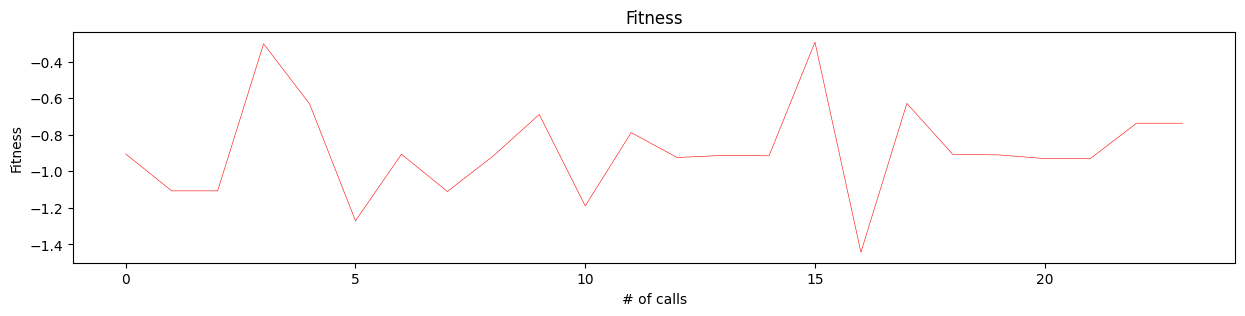

<Figure size 1500x300 with 0 Axes>

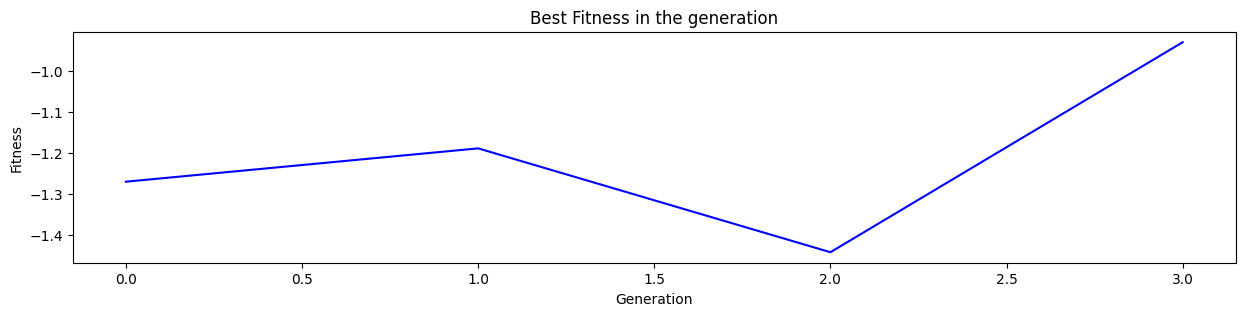

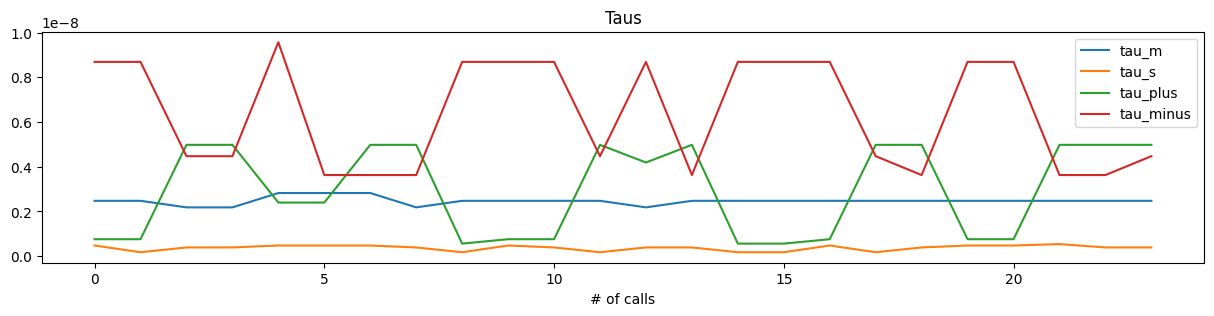

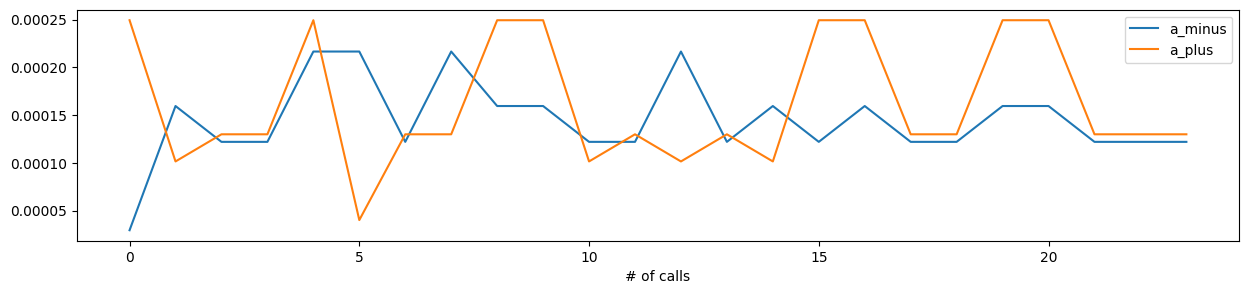

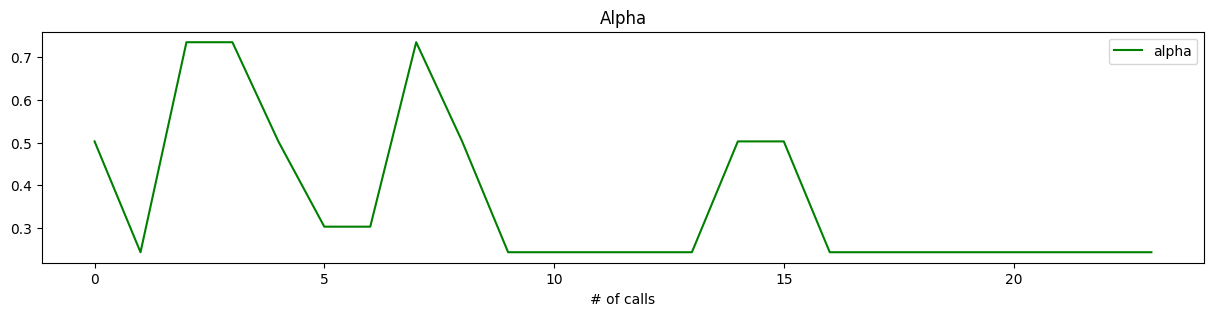

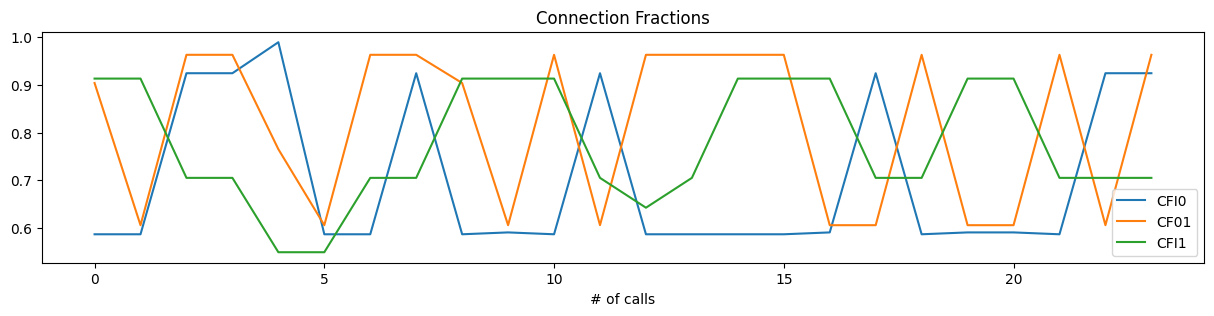

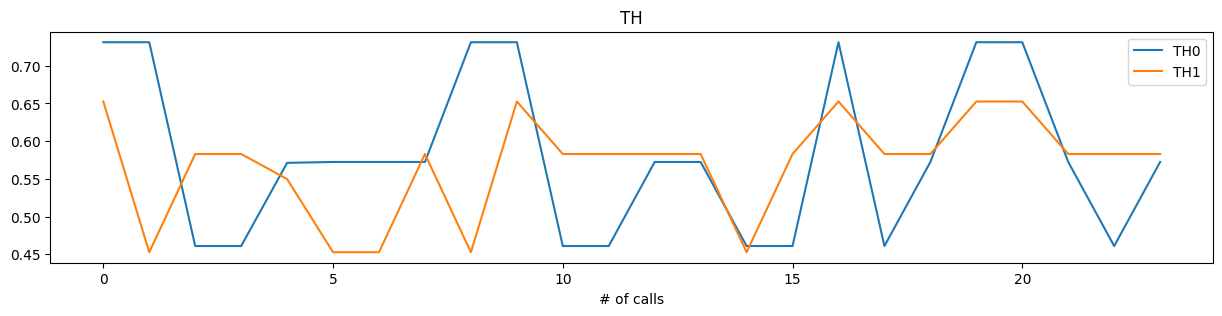

In [9]:
#read the values.csv
df = pd.read_csv('values.csv')

# df = pd.read_csv('ga_0_01_negfitn.csv')
# df = pd.read_csv('ga_0_1_posfitness.csv')



plt.figure(figsize=(15,3))
plt.plot(df['fitness'], 'r-', linewidth = 0.4)
plt.title('Fitness')
plt.xlabel('# of calls')
plt.ylabel('Fitness')
plt.show()


#adjust the figure size
plt.figure(figsize=(15,3))
#plot the fitness
pop_fit = []
best_generat = []
j = 0 
for i in range(len(df['fitness'])):
    j = j + 1
    pop_fit.append(df['fitness'][i])

    if j == population_size:
        best_generat.append(np.min(pop_fit))
        j = 0
        pop_fit = []
        
plt.figure(figsize=(15,3))
plt.plot(best_generat, 'b-')
plt.title('Best Fitness in the generation')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()


#plot the taus
plt.figure(figsize=(15,3))
plt.plot(df['tau_m'], label='tau_m')
plt.plot(df['tau_s'], label='tau_s')
plt.plot(df['tau_plus'], label='tau_plus')
plt.plot(df['tau_minus'], label='tau_minus')
plt.title('Taus')
plt.xlabel('# of calls')
plt.legend()
plt.show()

#plt the a 
plt.figure(figsize=(15,3))
plt.plot(df['a_minus'], label='a_minus')
plt.plot(df['a_plus'], label='a_plus')
plt.xlabel('# of calls')
plt.legend()
plt.show()


plt.figure(figsize=(15,3))
plt.plot(df['alpha'], label='alpha', color = 'green')
plt.xlabel('# of calls')
plt.title('Alpha')
plt.legend()
plt.show()

#plot the CFI
plt.figure(figsize=(15,3))
plt.plot(df['CFI0'], label='CFI0')
plt.plot(df['CF01'], label='CF01')
plt.plot(df['CFI1'], label='CFI1')
plt.xlabel('# of calls')
plt.title('Connection Fractions')
plt.legend()
plt.show()

#plot the TH
plt.figure(figsize=(15,3))
plt.plot(df['TH0'], label='TH0')
plt.plot(df['TH1'], label='TH1')
plt.xlabel('# of calls')
plt.title('TH')
plt.legend()
plt.show()


In [ ]:
#find the best fitness and the corresponding paraemters
best_fitness = df['fitness'].min()
best_parameters = df[df['fitness'] == best_fitness]
best_parameters


,tau_m,tau_s,tau_plus,tau_minus,a_minus,a_plus,CFI0,CF01,CFI1,alpha,TH0,TH1,fitness
127,1.217742e-09,7.702346e-10,6.288915e-09,7.193506e-09,0.000126,0.000109,0.552786,0.565982,0.663245,0.66129,0.867742,0.459629,-7.26428
130,1.217742e-09,7.702346e-10,6.288915e-09,7.193506e-09,0.000126,0.000109,0.552786,0.565982,0.663245,0.66129,0.867742,0.459629,-7.26428
131,1.217742e-09,7.702346e-10,6.288915e-09,7.193506e-09,0.000126,0.000109,0.552786,0.565982,0.663245,0.66129,0.867742,0.459629,-7.26428


In [ ]:
# !../SNNT13.out --N_ev 2000 --tau_m 1.21e-9 --tau_s 7.70e-10 --tau_plus 6.28e-9 --tau_minus 7.19e-9 --a_plus 0.000109 --a_minus 0.000126 --CFI0 0.55 --CF01 0.56 --CFI1 0.66 --alpha 0.66 --TH0 0.86 --TH1 0.45



                                 ------------------------------------

                                    S   N   N      T r a c k i n g

                                 ------------------------------------




         ------------------------------------------------------------------------------------    
         Unsupervised search for tracks in 8-layer strip detector with spiking neural network    
                                                                             T.Dorigo, 3/2023    
         ------------------------------------------------------------------------------------    

         Run parameters: 
         -----------------------------------
                       L0 neurons: 6
                       L1 neurons: 6
            Connected L0-L1 frac.: 0.56
            Connected IN-L0 frac.: 0.55
            Connected IN-L1 frac.: 0.66
                    Track classes: 6
                     Total events: 2000
               Optimization loops: 1
             

Python(73831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In file included from input_line_3:38:
In file included from /Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/c++/v1/cassert:19:
In file included from /Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/c++/v1/__assert:14:
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/c++/v1/__verbose_abort:24:18: error: unknown type name '_LIBCPP_AVAILABILITY_VERBOSE_ABORT'
_LIBCPP_NORETURN _LIBCPP_AVAILABILITY_VERBOSE_ABORT _LIBCPP_OVERRIDABLE_FUNC_VIS _LIBCPP_ATTRIBUTE_FORMAT(__printf__, 1, 2)
                 ^
         -----------------------------------

         Starting values of parameters:
         -----------------------------------
                     L0 threshold: 0.86
                     L1 threshold: 0.45
                            alpha: 0.66
                        L1inhibit: 1
                                K: